# Recaudación y análisis de información política a través de la red de Twitter

***

## Índice

1. Introducción
2. Preámbulo
3. Data scraping
   1. Elección de usuarios
   2. Recolección de la red de usuarios
   3. Recolección de información de los usuarios
4. Análisis de atributos obtenidos

5. Análisis macro de la red obtenida
   1. Análisis de comunidades en la red
      1. Primera intuición
      2. Algoritmo de modularidad provisto por Gephi
      3. Estudio de orientación política de los usuarios de la red mediante etiquetado manual
      4. Predicciones usando Graph Neural Networks

6. Análisis de los actores de la red según distintas centralidades
7. Conclusiones
8. Trabajo futuro

---

## 1. Introducción

En los últimos años se ha visto una gran [tendencia a la polarización](https://ideas.repec.org/p/ces/ceswps/_1798.html) social a nivel mundial. Varios autores plantean que las redes sociales y cómo interactuamos con ellas [juegan un papel fundamental en esta polarización](https://greatergood.berkeley.edu/article/item/is_social_media_driving_political_polarization), siendo que las mismas facilitan (por su naturaleza) la propiedad de asortatividad u homofilia (tendencia que tienen los nodos de una red a unirse a otros que le son similares en alguna característica).

Estamos a un sólo click de dejar de ver contenido que nos resulta irrelevante, molesto o simplemente no está alineado con nuestro pensar. A su vez, los algoritmos de descubrimiento de las redes sociales se alimentan de esta información para sugerirnos más contenido de nuestro agrado con el afán de ganar nuestra atención y con esto aumentar su valor al poder venderle publicidad cada vez más segmentada a los anunciantes: es más probable que una persona que consume contenido de usuarios que promueven productos veganos compre un nuevo producto vegano a que un usuario consumidor de carne lo haga.

Nuestra región no es ajena a ninguna de las características descriptas en los anteriores párrafos. La cantidad de usuarios activos en las redes sociales ha aumentado año a año así como la polarización (más conocida como [la grieta](https://es.wikipedia.org/wiki/La_grieta_%28Argentina%29) en nuestra región). En las [pasadas elecciones presidenciales](https://es.wikipedia.org/wiki/Elecciones_generales_de_Uruguay_de_2019), Uruguay también ha seguido esta tendencia habiéndose conformado una especie de bipartidismo con la conformación de la nueva [Coalición Multicolor](https://es.wikipedia.org/wiki/Coalici%C3%B3n_Multicolor) cuyo objetivo fue evitar el continuismo del Partido que gobernó durante 15 años nuestro país: el [Frente Amplio](https://es.wikipedia.org/wiki/Frente_Amplio_(Uruguay)).

El pasado domingo 27 de setiembre del 2020 se celebraron las Elecciones Departamentales y Municipales en Uruguay. Por tal motivo, las redes no estuvieron exentas de debate en los días previos frente a distintos acontecimientos.
En el presente informe se intentó recolectar y analizar información de la red Twitter para analizar el fenómeno anteriormente descripto en nuestro país utilizando herramientas de Social Network Análisis.

Durante este proyecto se creará una red de usuarios de Twitter en Uruguay utilizando [la API oficial de Twitter](https://developer.twitter.com/en/products/twitter-api) para su posterior estudio. Dicha API tiene muchas restricciones y limitaciones (por ejemplo: el _endpoint_ para obtener los seguidores de un usuario admite 15 requests cada 15 minutos, donde cada request devuelve a lo sumo 100 seguidores), por lo que obtener y darle forma de grafo a los datos llevará un tiempo significativo del trabajo.

#### Como motivación se intentará responder las siguientes preguntas:
- ¿Hay usuarios más influyentes en esta red? ¿Cuáles son?
- ¿Los usuarios de Twitter forman comunidades por afinidades políticas?
- ¿Qué tamaño suelen tener estas comunidades?
- ¿Existen comunidades aisladas del resto? ¿Qué tan aisladas están?
- ¿Es posible clusterizar a los usuarios según afinidad política a la Coalición Multicolor o al Frente Amplio?

---

## 2. Preámbulo

El [Social network Analysis](https://es.wikipedia.org/wiki/An%C3%A1lisis_de_redes_sociales) es el proceso de investigar estructuras sociales mediante el uso de redes y la teoría de grafos. Las redes están compuestas de nodos y enlaces que los unen. El objetivo es analizar este conjunto estudiando los subgrupos de afinidades, la centralidad o importancia relativa de los nodos, su relevancia y qué rol juegan en dicha red, entre otros aspectos que sean pertinentes en cada caso.

Los nodos de la red representan a los personajes, actores, grupos o lo que se quiera modelar, y los enlaces representan relaciones existentes entre estas entidades que interactúan en la red.

***

## 3. Data scraping

### 3.A) Elección de usuarios
Según trabajos previos consultados, cuando se quiere recabar información de una región en particular, se recomienda utilizar la [funcionalidad de recuperación de información por texto](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets) que brinda la API de Twitter utilizando un _tema de nicho_ característico de la población a estudiar. Este _endpoint_ nos permite recuperar todos los tweets de los últimos siete días que contengan determinado texto en él.

Inicialmente se eligió recuperar toda la información de los tweets que contuvieran el _hashtag_ **#EleccionesDepartamentales2020**. Cuando comenzó el estudio de dicha información, tuvo que ser descartada ya que se notó que un porcentaje muy grande de los que usaban este _hashtag_ eran cuentas oficiales de medios de comunicación y no tanto usuarios particulares. Por este motivo, y dada la cercanía con la realización de la [Rural del Prado](https://www.expoprado.com/programas-2020/) y la polémica generada por los [cuestionados protocolos sanitarios incumplidos](https://ladiaria.com.uy/politica/articulo/2020/9/intendencia-de-montevideo-sancionara-a-la-aru-por-incumplir-protocolo-sanitario-en-la-expo-prado/), se prosiguió a recabar la información de los tuits que contuvieran la expresión exacta **"Rural del Prado"**.

### 3.B) Recolección de la red de usuarios
Se importan las librerías para el manejo de información. Se utiliza la biblioteca **tweepy** para realizar la comunicación con la API de Twitter de forma más sencilla:

In [1]:
import tweepy
import csv
import pandas as pd
import time
import sys

Para hacer efectiva la recolección de información se tuvo que aplicar para obtener una cuenta de Desarrollador en Twitter en el [presente link](https://developer.twitter.com/en/apply-for-access) y una vez aprobada se obtuvieron credenciales para acceder a la API (las cuales serán modificadas en el presente informe por obvias razones).

In [3]:
# Credenciales de la API de Twitter modificadas
consumer_key = "1ORGJsOKT6h6GkLR2a6G"
consumer_secret = "wqiy783awcqSxsJHq3XKXU9wcqrmxfp6HHoqd9BrWnAe"
access_key = "218970468-v43uk19hYaNto5XuwaN3Zj3yGJueYtyK5eVA"
access_secret = "IQyJhTs27has3oRA2Fa7OEkj1FpjSbvXJTvAK"

Se configura el objeto encargado de gestionar la conexión con la API de Twitter utilizando las credenciales obtenidas luego de que la cuenta de desarrollador fuera aprobada. Vale destacar que la librería **tweepy** permite configurar el parámetro **wait_on_rate_limit** que se encarga de esperar el tiempo necesario cada vez que se vence el _rate_ de pedidos a la API gratuita de Twitter, evitando así que la cuenta de desarrollador sea bloqueada por pedidos excesivos.

In [4]:
OAUTH_KEYS = {'consumer_key':consumer_key, 'consumer_secret':consumer_secret, 'access_token_key':access_key, 'access_token_secret':access_secret}
auth = tweepy.OAuthHandler(OAUTH_KEYS['consumer_key'], OAUTH_KEYS['consumer_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Se configura la búsqueda a realizar, trayendo los últimos 4000 tweets que contienen la query **Rural del Prado** en ellos.

In [ ]:
search = tweepy.Cursor(api.search, q='Rural del Prado').items(4000)

A continuación se muestran algunos tweets recabados

In [2]:
df = pd.read_csv("tweets_rural_del_prado.csv")
df.sample(10)

,screen_names,texts
321,MMartinez_V,RT @aguslopez97: Bo que onda esa doble moral p...
2234,MariaPe07593237,RT @sebas166019: Monseñor Sturla estuvo en la ...
2066,clau_gomez33,RT @Rusticaaa: Y en la rural del prado entran ...
311,mathiascamia2,"RT @AlfTuitea: Para la próxima ya sabemos, que..."
2642,Patricia110011,"RT @ObservadorAgro: ""Lo raro sería que el gobi..."
337,Ilimepa,"RT @AlfTuitea: Para la próxima ya sabemos, que..."
246,AnaJesu40725925,RT @gera_nunez1001: Mucho indignado con la mar...
1833,MaccioRolly,Los mismos que se molestaron por la rural del ...
1248,Mica_Carrea,"RT @freedomparadyse: che, por la rural del pra..."
2736,NiFulana,RT @sebas166019: No fue presidente de la ARU. ...


In [3]:
len(df['screen_names'].unique())

2579

Creamos una lista con los nombres de usuarios sin repetir para luego iterar sobre ellos y obtener la lista de a quiénes sigue cada uno. La elección de obtener la lista de a quién sigue una cuenta, en lugar de sus seguidores es intencional. Si bien cualquiera de las dos opciones debería funcionar, la mayoría de los usuarios de Twitter siguen menos personas de las que lo siguen, especialmente los influyentes y famosos. De esta forma reducimos el número de llamadas a la API de Twitter.

**_La siguiente ejecución tomó al rededor de una semana, con varias caídas de conexión y el uso de técnicas para continuar la recolección donde la misma se había caído. De todas formas se presenta la primera versión del código para facilitar su lectura_.**

In [ ]:
all_names = list(df['screen_names'].unique())
nameCount = len(all_names)
count = 0

for name in all_names:
    # Construcción de usuarios seguidos  
    currentFriends = []
    for page in tweepy.Cursor(api.friends_ids, screen_name=name).pages():
        currentFriends.extend(page)
    currentId = api.get_user(screen_name=name).id
    currentId = [currentId] * len(currentFriends)
    currentName = [name] * len(currentFriends)   
    dfTemp = pd.DataFrame()
    dfTemp['userFromName'] = currentName
    dfTemp['userFromId'] = currentId
    dfTemp['userToId'] = currentFriends
    dfUsers = pd.concat([dfUsers,dfTemp])
    count +=1
    per = round(count*100.0/nameCount,1)
    sys.stdout.write("\r %s%% completado." % per)
    sys.stdout.flush()  

Se hacen algunas modificaciones al dataframe para que sea más fácil la construcción de un grafo en el siguiente paso:

En la columna `userFromId` se tiene el id del usuario que sigue al usuario `userToId`. Con esta información y la de sus nombres de usuarios contenidos en `userFromName` y `userToName` se construirá el grafo de la red.

In [ ]:
fromId = dfUsers['userFromId'].unique()
dfChat = dfUsers[dfUsers['userToId'].apply(lambda x: x in fromId)]
dfLookup = dfChat[['userFromName','userFromId']]
dfLookup = dfLookup.drop_duplicates()
dfLookup.columns = ['userToName','userToId']
dfCommunity = dfUsers.merge(dfLookup, on='userToId')

#### Aquí se muestra cómo queda el archivo con la información que formará la red a estudiar

In [3]:
df = pd.read_csv("dfCommunity_rural_2.csv")
df.sample(10)[['userFromName', 'userToName']]

,userFromName,userToName
6531,getchandy,miguelc471
14418,Lahamgatt,marygambler
1352,LizetElizabeth,diegodelacurva
5296,Eduardo03199510,jgsp12071979
17833,MonicaBatlle4,PabloUrquizo
1954,Lahamgatt,JUrruzola
12185,rhunlander,PNACIONAL
2493,PosseNancy59,RominaPesce5
13163,AliciaB11037130,kamba_lucy
8668,LUISGILTORRES19,unpescador


### 3.C) Recolección de información de los usuarios

Utilizando la API de Twitter nuevamente, se recupera la escasa información que provee dicha red de cada nodo para lograr comprender más los datos y tener más herramientas para su futura clasificación.

#### Es por esto que se construye el siguiente script que recauda información de los nodos recuperados en la sección anterior para proceder con el estudio de los datos:

In [ ]:
comunidad = pd.read_csv('dfCommunity_rural_2.csv')
lista_1 = comunidad['userFromId'].tolist()
lista_2 = comunidad['userToId'].tolist()
ids_unicos = list(set(lista_1 + lista_2))

batches = np.array_split(np.array(ids_unicos), 13)
res = []
for batch in batches:
    res.append(api.lookup_users(user_id=','.join(list(map(str,batch.astype(int))))))

users_objects = []
for batch in res:
    for user in batch:
        users_objects.append(user)

columns = ['id_str', 'screen_name', 'location', 'description', 'protected', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'created_at']
users = pd.DataFrame(columns=columns)
for user in users_objects:
    row = pd.Series({'id_str': user.id_str, 'screen_name': user.screen_name, 'location': user.location, 'description': user.description, 'protected': user.protected, 'verified':user.verified, 'followers_count':user.followers_count, 'friends_count': user.friends_count, 'created_at': user.created_at, 'statuses_count':user.statuses_count})
    users = users.append(row,ignore_index=True)
users.to_csv('users_info.csv', index = False)

In [5]:
users = pd.read_csv('users_info.csv')
users.head(5)

,id_str,screen_name,location,description,protected,verified,followers_count,friends_count,statuses_count,created_at
0,1192212972497784832,MonicaBatlle4,"Montevideo, Uruguay",Medica Diabetologa Tricolor a muerte,False,False,4557,4126,18797,2019-11-06 22:51:51
1,1200462903943606272,Rojoazulyblanc1,NaN,obrero y frenteamplista,False,False,1193,2027,13615,2019-11-29 17:14:06
2,1039958979420610560,congresofa,Uruguay,Grupo Político Congreso Frenteamplista. Anti -...,False,False,3149,4848,29161,2018-09-12 19:28:36
3,716381190719148032,ojopterouy,Uruguay,Ingeniero Agrónomo,False,False,651,1311,3837,2016-04-02 21:46:00
4,1293553798204489728,LadiLilian,NaN,"Nolesimportanada,total hacen lo que quieren",False,False,438,599,5938,2020-08-12 14:24:23


### De todos los datos, por cuestiones de esfuerzo, se tendrán en cuenta sólo los numéricos. En este sentido, se transformarán los booleanos tomando el siguiente criterio: **False** será **0** y **True** 1. 

In [7]:
enum_columns = ['protected', 'verified', 'followers_count', 'friends_count', 'statuses_count']
numbers = users[enum_columns].astype(int)

### Luego de la transformación, el dataset luce de la siguiente forma:

In [8]:
numbers.head(6)

,protected,verified,followers_count,friends_count,statuses_count
0,0,0,4557,4126,18797
1,0,0,1193,2027,13615
2,0,0,3149,4848,29161
3,0,0,651,1311,3837
4,0,0,438,599,5938
5,0,0,97,565,4471


***


## 4) Análisis de atributos obtenidos
En esta sección se intenta obtener información de los datos utilizando técnicas estadísticas y de visualización

#### Comenzamos estudiando la correlación entre las variables que representan los datos utilizando una matriz de correlación

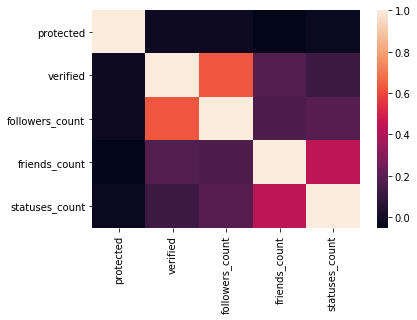

In [9]:
import seaborn as sn
sn.heatmap(numbers.corr(), annot=False)

### De esta matriz podemos deducir cuáles son las variables con mayor relación y se listan en orden:
#### 1. followers_count y verified

La estrecha relación (0.628067) entre estas dos variables no debería llamar la atención. Esto se debe a que el campo `verified` implica que dicha cuenta ha pasado una revisión manual por parte del equipo de Twitter, [confirmando que son cuentas de interés público](https://help.twitter.com/es/managing-your-account/about-twitter-verified-accounts). Algunos ejemplos de cuentas verificadas son: famosos, políticos, empresas, entre otras entidades con exposición mediática, quienes naturalmente serán más conocidos (y se reflejará en cantidad de seguidores).

#### 2. statuses_count y friends_count
Si bien la relación entre estas dos variables (0.437237) no es tan directa como la anterior, la cantidad de publicaciones que hace un usuario (`statuses_count`) y la cantidad de personas que sigue (`friends_count`) podrían ser una medida de qué tanto usa la red un usuario.

### 4.A) Análisis de atributos

### a) Atributo `created_at` (fecha de creación de la cuenta)

#### A continuación realizamos un histograma de las fechas en las que los usuarios se unieron a la red:

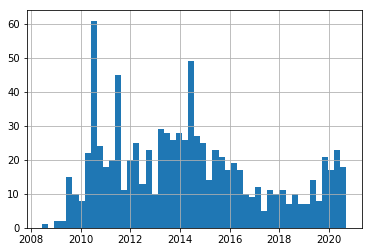

In [18]:
users.created_at.astype("datetime64").hist(bins=50)

Puede apreciarse la varianza de dicha variable, teniendo un máximo de usuarios registrados a fines del 2010 aunque con varios picos dispares.

### b) Atributo `followers_count` (cantidad de seguidores)
#### A continuación realizamos un histograma de la cantidad de seguidores de cada usuario, el mismo representa la distribución de grado de la red:

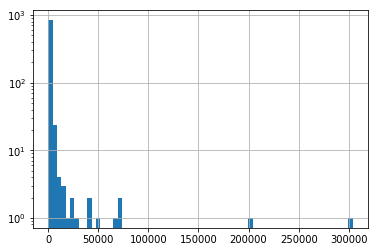

In [23]:
fig = pd.to_numeric(users.followers_count).hist(bins=70)
fig.set_yscale('log')

Podemos afirmar que la distribución se asemeja aunque muy poco a una distribución power-law, que generalmente es la que describe a este tipo de redes.

In [31]:
users.followers_count.describe()

count       879.000000
mean       1999.689420
std       13327.293523
min           5.000000
25%         152.500000
50%         424.000000
75%        1023.500000
max      303904.000000
Name: followers_count, dtype: float64

En este gráfico puede apreciarse cómo la inmensa mayoría de los usuarios tienen relativamente baja cantidad de seguidores comparado con unos pocos que concentran grande cantidades. Esto también puede verse con la gran desviación que presentan los datos.

### c) Atributo `friends_count` (cantidad de usuarios seguidos)
#### A continuación realizamos un histograma de la cantidad de usuarios que sigue cada cuenta:

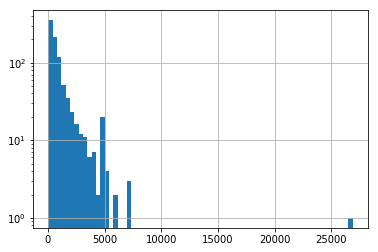

In [33]:
fig_2 = pd.to_numeric(users.friends_count).hist(bins=70)
fig_2.set_yscale('log')

In [34]:
users.friends_count.describe()

count      879.000000
mean       957.063709
std       1431.684507
min         22.000000
25%        253.500000
50%        534.000000
75%       1051.000000
max      26888.000000
Name: friends_count, dtype: float64

### d) Atributo `location` (ubicación geográfica)
#### A continuación se expresan las decisiones tomadas con respecto a este atributo

Listamos 10 ejemplos aleatorios para ver cómo lucen:

In [21]:
users['location'].sample(10)

164                        Uruguay
833                            NaN
708            Montevideo, Uruguay
427                        Uruguay
599                            NaN
24             Montevideo, Uruguay
399                            NaN
673           Uruguay -. Canelones
726    Ciudad de la costa, Uruguay
385                     Cuarentena
Name: location, dtype: object

Un gran porcentaje de los usuarios no tienen su ubicación configurada, tienen ubicaciones ficticias o no válidas. Además de esto, la misma ubicación puede estar representada de distintas formas debido a que Twitter permite ingresar la misma como un string libre en lugar de seleccionar dentro de una lista de válidas.

Esto puede apreciarse simplemente viendo la cantidad de `locations` distintas dentro del total de usuarios que tuitearon la expresión **"Rural del Prado"**:

In [32]:
len(users['location'].unique())

219

Si bien resultaría interesante contrastar la información de la localidad de las cuentas con la asunción de que las mismas son efectivamente de Uruguay, por razones de tiempo no se harán en el presente trabajo ya que implicarían la utilización de técnicas de procesamiento de lenguaje natural sobre el atributo de localidad.




***

## 5) Análisis macro de la red obtenida

De la recolección de datos se obtienen una matriz $T \in \mathbb{R}^{2 \times 22636}$ donde cada fila $t_{i}=(t_{i1},t_{i2})$ indica que el usuario con $id=t_{i1}$ sigue al usuario con $id=t_{i2}$ y su matriz equivalente conteniendo nombres de usuarios.

De la matriz $T$ se construye el grafo a estudiar $G$ de la siguiente manera:
- Los nodos (vértices) $v \in G$ de la red serán usuarios de Twitter
- Habrá una arista $e=(v_1,v_2)$ **dirigida** entre un par de nodos si el usuario $v_1$ sigue al usuario $v_2$

Del grafo $G$ se obtiene una red compuesta por 1224 nodos y 22636 aristas. La misma está dividida en 7 componentes conexas, donde se distingue una componente gigante con 1211 nodos y 22622 aristas que la conectan. Dicha componente contiene el 98.94% del total de nodos así como el 99.94% del total de aristas. 

### 5.1) Análisis de comunidades en la red
En esta parte se utilizan distintas técnicas para clasificar a los usuarios en distintos grupos según determinados algoritmos o decisiones que se explicitarán.

### a) Primera intuición
Se dibuja el grafo con el algoritmo Force Atlas, con una repulsión y atracción de 1000 y 10 respectivamente:

![imagen1](img/1.png)
<center><b>(Imagen 1)</b></center>

A simple vista puede verse cómo el algoritmo por sí solo concentra a los vértices en 2 grandes grupos, habiendo otro grupo de vértices que se encuentran equidistantes a ambos clusters. 
Se le aplican técnicas de corte estético al grafo para que se puedan observar de forma más clara los tres grupos. En la siguiente figura se distinguen en colores rojo, azul y verde respectivamente:

![imagen1](img/2.png)
<center><b>(Imagen 2)</b></center>

### b) Algoritmo de modularidad provisto por Gephi

Para estudiar con mayor profundidad las agrupaciones, se corre el algoritmo de modularidad provisto por Gephi. 

La modularidad de una red es una medida de qué tan conectados están los nodos pertenecientes a un mismo cluster. Una modularidad alta indica conexiones densas entre los nodos de un mismo cluster aunque conexiones esparzas entre los actores de distintos clusters. La modularidad de nuestra red es de 0.432, considerablemente alta. 

Por otro lado, una medida que nos da una idea similar es el coeficiente de clustering. El mismo representa la fracción de los vecinos que están conectados entre sí. En nuestra red es de 0.306 en promedio, por lo que aproximadamente uno de cada tres vecinos está conectado entre sí.

**En la siguiente imagen se puede apreciar el resultado de calcular los clusters de la red:**
![imagen3](img/3.png)

<center><b>(Imagen 3)</b></center>

![imagen4](img/4.png)


Con el algoritmo de detección de comunidades encontramos 4 clases principales que concentran el 97.39% de los usuarios. Las mismas coinciden en gran proporción con las inicialmente dibujadas en la **figura 2**.

### c) Estudio de orientación política de los usuarios de la red mediante etiquetado manual:
Para estudiar una posible inclinación ideológica dentro de las clases (clusters) detectadas y con el fin de contrastar la información predicha con información real, se prosiguió a tomar los 150 usuarios usuarios con mayor PageRank de la red (**sección 5**) y analizar sus perfiles.

De los 150 usuarios analizados puede decirse que se pudo clasificar sin problema a 106 de ellos (8.74% del total de los nodos de la red) en 5 categorías: **Periodista**, **Medio**, **Institucional**, **Frente Amplio** y **Coalición Multicolor**.

De los restantes 44 no se encontró evidencia suficiente para clasificarlos en ninguna de las anteriores categorías tomándose un criterio conservador ante la elección de la clase.

El análisis de perfiles consistió en leer su descripción, foto de perfil y [tweet fijado](https://www.quora.com/What-is-a-pinned-tweet-and-how-do-I-do-one) y através de ellos inferir su identificación política si así fuera posible. Por más que parezca complejo, este proceso fue más simple de lo esperado por la información que contenían los perfiles de usuarios (esto podría ser por la cercanía a las Elecciones Nacionales y las Departamentales).

La eficacia de este procedimiento puede resultar cuestionable por la subjetividad del clasificador, aunque se hace énfasis en que se tomó una postura conservadora a la hora de clasificar cuando no había suficientes datos. Esta postura llevó a que casi un tercio de los perfiles visitados no fueran incluidos en ninguna categoría a pesar de tener algo de información sobre ellos.

Por estos motivos se presentan algunas algunas capturas de forma de transparentar el proceso:

#### Ejemplos clasificados como Frente Amplio:
![imagen5](img/5.png)

#### Ejemplos clasificados como Coalición Multicolor:
![imagen6](img/6.png)

#### Ejemplos no clasificados::
![imagen7](img/7.png)

#### A continuación puede apreciarse el grafo con la coloración correspondiente a las nuevas clases manualmente etiquetadas:
![imagen8](img/8.png)
![image9](img/9.png)

De los datos etiquetados gran porcentaje coincide con la clase de modularidad asociada por el algoritmo provisto por Gephi.

En el siguiente punteo se listan algunas relaciones entre las etiquetas elegidas y las clasificaciones hechas por el algoritmo de clustering.

- El 100% de los etiquetados como frenteamplistas pertenecen a la clase 5
- El 100% de los etiquetados como Coalición Multicolor pertenecen a la clase 3
- En su mayoría, las cuentas etiquetadas como medios o institucional pertenecen a las clases 4, 3 y 5 en ese orden de prioridad. A su vez, medios que son asociados a la izquierda (como M24) pertenece al cluster con número 3 donde se encuentran los usuarios vinculados con votantes del Frente Amplio así como medios asociados con la derecha (El Observador, El País) pertenecen principalmente al cluster 5 donde dominan los simpatizantes de la Coalición Multicolor. Asumiendo estas hipótesis podría explicarse que esto sucede por la homofilia entre los usuarios al consumir información de cuentas con orientaciones políticas similares.


### d) Graph Neural Networks
En esta sección se intentará utilizar Graph Neural Networks, una herramienta relativamente nueva para el estudio de grafos utilizando [Redes Neuronales Convolucionales](https://es.wikipedia.org/wiki/Redes_neuronales_convolucionales) en las cuales se utilizan capas del tipo `GraphConv` (provistas por la librería [Spektral](https://graphneural.network/)) donde, además de tener en cuenta la matriz de adyacencias del grafo, se toman características del propio grafo a la hora de predecir etiquetas de nodos o aritas.


En este caso se utilizarán en una simplificación de problema donde se convierte el problema a una clasificación binaria intentando predecir si los nodos del grafo tendrán la etiqueta "FA" o "CM" representando `Frente Amplio` y `Coalición Multicolor` respectivamente.


Para esto se necesitan importar las siguientes librerías:

In [20]:
import networkx as nx
import scipy.sparse as sparse
import numpy as np
import matplotlib
import pandas as pd
from matplotlib.colors import ListedColormap
import tensorflow as tf
import matplotlib.pyplot

Para proceder con la clasificación previamente descrita, la librería nos exige que las entradas del algoritmo sean las siguientes:

- **A**: Matriz de adyacencias del grafo
- **X**: Matriz con features de los nodos del grafo
- **y**: Matriz con etiquetas 'FA' o 'CM' (de forma one-hot endoded)
- **train_mask**, **validating_mask**, **testing_mask** máscaras que seleccionan qué nodos se usarán en cada uno de los pasos de entrenamiento, validación y testeo.

In [21]:
graph = nx.read_gexf('grafo_ultimo.gexf', node_type=None, relabel=False)
adj_matrix = nx.adjacency_matrix(graph)

A continuación se grafica la matriz de adyacencias del grafo para tener una idea de qué tan esparsa es:

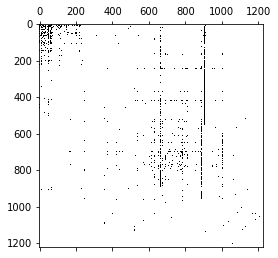

In [22]:
cmap = ListedColormap(['white', 'black'])
matplotlib.pyplot.matshow(adj_matrix, cmap=cmap)

Para continuar, se agrega la información recaudada de cada usuario a su respectivo nodo para tenerlos dentro de la matriz **X**. 

Como fue previamente comentado, se quitarán las etiquetas de `Periodista`, `Medio`, `Institucional` y se codifican las etiquetas a 0, 1.

In [23]:
dataset = pd.read_csv("perfiles_etiquetados.csv")
users = pd.read_csv("users_info.csv")
dataset.rename(columns={'Label':'screen_name'}, inplace=True)
full_dataset = pd.merge(dataset,users,on='screen_name',how='left')

full_dataset = full_dataset.replace({'medio': np.nan })
full_dataset = full_dataset.replace({'periodista': np.nan })
full_dataset = full_dataset.replace({'institucional': np.nan })
full_dataset = full_dataset.replace({'fa': 0 })
full_dataset = full_dataset.replace({'cm': 1 })

El dataset luce de la siguiente forma y en él se puede ver cómo no se pudo recuperar la información de varios nodos de la red. Esto se debe a que la recolección de usuarios de la red y la recolección de su información de perfil se hicieron con un tiempo relativamente grande de diferencia (2 semanas después), por lo que los usuarios podrían haber cambiado la privacidad de su cuenta, el nombre de usuario o bien pudieron desactivar su cuenta.

In [24]:
full_dataset.head(6)

,Id,screen_name,timeset,afinidad,modularity_class,pageranks,indegree,outdegree,Degree,Eccentricity,...,eigencentrality,id_str,location,description,protected,verified,followers_count,friends_count,statuses_count,created_at
0,1052916459834364032,MillorLujan,NaN,NaN,5,0.000266,7,13,20,7,...,0.069047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1192212972497784832,MonicaBatlle4,NaN,NaN,3,0.002817,142,205,347,6,...,0.482481,1.192213e+18,"Montevideo, Uruguay",Medica Diabetologa Tricolor a muerte,False,False,4557.0,4126.0,18797.0,2019-11-06 22:51:51
2,427830008,ubidominans,NaN,NaN,5,0.002089,84,37,121,6,...,0.483722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1367991289,laresistencia72,NaN,NaN,5,0.000727,29,54,83,6,...,0.235189,1.367991e+09,Uruguayo,''Que En Todos Lados Se Vea El Poder De La Cla...,False,False,383.0,839.0,2067.0,2013-04-20 20:51:14
4,938192801023561600,Sofamansillaeco,NaN,NaN,5,0.000272,6,9,15,7,...,0.055201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1045117028733001600,Mabel546,NaN,0.0,5,0.001398,64,73,137,6,...,0.480269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se separa tanto la clasificación de cada nodo así como la clase de modularidad de los nodos para que el algoritmo no tenga en cuenta esta información a la hora de predecir las clases. Se necesitará saber el índice de cada etiqueta predicha, así que la se guardan en la variable `index_of_labeled`.


Además se elimina la información que no sea numérica, ya que el algoritmo sólo admite datos de este tipo en su entrada.

In [25]:
labels = full_dataset['afinidad']
index_of_labeled = labels[labels.notnull()].index
full_dataset = full_dataset.drop(columns=['afinidad', 'protected', 'verified', 'location', 'description', 'Id', 'screen_name', 'timeset', 'modularity_class', 'componentnumber', 'strongcompnum', 'indegree', 'outdegree', 'Degree', 'Eccentricity', 'id_str', 'created_at'])

Como aún se sigue con información faltante (como la cantidad de seguidores de algunos usuarios, cantidad de usuarios que siguen o cantidad de tuits) se sustituye la información faltante por la media del respectivo atributo:

In [26]:
full_dataset = full_dataset.fillna(full_dataset.mean())
full_dataset

,pageranks,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,Authority,Hub,clustering,eigencentrality,followers_count,friends_count,statuses_count
0,0.000266,0.320755,0.355198,0.000001,0.005914,0.013885,0.620879,0.069047,2027.00232,966.518561,23077.184455
1,0.002817,0.410276,0.508049,0.028870,0.119300,0.137382,0.136201,0.482481,4557.00000,4126.000000,18797.000000
2,0.002089,0.344670,0.386591,0.004461,0.042358,0.022055,0.285014,0.483722,2027.00232,966.518561,23077.184455
3,0.000727,0.361454,0.410073,0.002988,0.019821,0.033001,0.470999,0.235189,383.00000,839.000000,2067.000000
4,0.000272,0.313411,0.344271,0.000093,0.004358,0.008175,0.344444,0.055201,2027.00232,966.518561,23077.184455
...,...,...,...,...,...,...,...,...,...,...,...
1219,0.000630,0.666667,0.750000,0.000000,0.000000,0.000000,0.000000,0.000063,175.00000,265.000000,4091.000000
1220,0.000215,0.210674,0.219191,0.001612,0.000052,0.000000,0.000000,0.000083,272.00000,515.000000,5520.000000
1221,0.001192,1.000000,1.000000,0.000001,0.000000,0.000000,0.000000,0.000115,2027.00232,966.518561,23077.184455
1222,0.000294,0.213015,0.222589,0.000000,0.000010,0.000033,0.000000,0.000400,342.00000,591.000000,15381.000000


De esta forma se obtiene un dataset sin información faltante.

Para facilitar la convergencia de los algoritmos es recomendado normalizar todos los atributos entre 0 y 1, es por eso que se calcula la norma de cada uno y se los divide entre ella:

In [27]:
from sklearn import preprocessing

x = full_dataset.values # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_labeled_dataset = pd.DataFrame(x_scaled)

scaled_matrix = scaled_labeled_dataset.to_numpy()

Seguido se construye la matriz de etiquetas `y` de tamaño 2xN donde **FA** es **0**, **CM** **1**, sin etiqueta **NaN**.

In [28]:
valid_labels_cm = labels.values
valid_labels_fa = 1 - valid_labels_cm
labels_matrix = [valid_labels_fa, valid_labels_cm]
labels_matrix = np.array(labels_matrix).transpose()

Para agregarle aleatoriedad a nuestro algoritmo, se toma de forma randómica 80\% de nuestros 92 nodos etiquetadas para entrenamiento y 20\% para test y validación (se utilizará el mismo conjunto por contar con acotada información).

In [29]:
np_index = np.array(index_of_labeled)
np.random.shuffle(np_index)
train_indices = np_index[1:72] # 80% para train
test_indices = np_index[72:-1] # 20 % test y validación

Una vez obtenidos los índices, se generan las máscaras necesarias y se sustituyen los **NaN** por -1 para que sean leídas por la red:

In [30]:
training_mask = np.zeros((len(labels),),dtype=bool)
testing_mask = np.zeros((len(labels),),dtype=bool)
validating_mask = np.zeros((len(labels),),dtype=bool)

training_mask[train_indices] = True
testing_mask[test_indices] = True
validating_mask[test_indices] = True

np.nan_to_num(adj_matrix, copy=False, nan=-1.0, posinf=-1.0, neginf=-1.0)
np.nan_to_num(scaled_matrix, copy=False, nan=-1.0, posinf=-1.0, neginf=-1.0)
np.nan_to_num(labels_matrix, copy=False, nan=-1.0, posinf=-1.0, neginf=-1.0)
np.nan_to_num(training_mask, copy=False, nan=False, posinf=False, neginf=False)
np.nan_to_num(testing_mask, copy=False, nan=False, posinf=False, neginf=False)
np.nan_to_num(validating_mask, copy=False, nan=False, posinf=False, neginf=False)

array([False, False, False, ..., False, False, False])

Guardamos el model en `model/model.ckpt`:

In [31]:
import os

checkpoint_path = "model/model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [86]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from spektral.layers import GraphConv

# Load data
A = adj_matrix
X = scaled_matrix
y = labels_matrix
train_mask = training_mask
val_mask = validating_mask
test_mask = testing_mask


# Parameters
channels = 16           # Number of channels in the first layer
N = X.shape[0]          # Number of nodes in the graph
F = X.shape[1]          # Original size of node features
n_classes = 2           # Number of classes
dropout = 0.01           # Dropout rate for the features
l2_reg = 5e-4 / 2       # L2 regularization rate
learning_rate = 1e-2    # Learning rate > => < epochs
epochs = 15             # Number of training epochs

# Preprocessing operations
fltr = GraphConv.preprocess(A).astype('f4')
#X = X.toarray()

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])
dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GraphConv(n_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

# Train model
validation_data = ([X, fltr], y, val_mask)
model.fit([X, fltr],
          y,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[cp_callback])

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([X, fltr],
                              y,
                              sample_weight=test_mask,
                              batch_size=N)
print('Done.\n'
      'Test loss: {}\n'
      'Test accuracy: {}'.format(*eval_results))

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 11)]         0                                            
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 11)           0           input_37[0][0]                   
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 1224)]       0                                            
__________________________________________________________________________________________________
graph_conv_36 (GraphConv)       (None, 16)           176         dropout_36[0][0]                 
                                                                 input_38[0][0]       

Una vez entrenado el modelo, (por facilidad) se compara las salidas predichas por el mismo con las clases de modularidad, las cuales parecen ser un muy buen clasificador.

Para esto recordamos que en su totalidad, los Frenteamplistas etiquetados manualmente forman parte de la clase de modularidad **5** mientras que los simpatizantes de la Coalición pertenecen a la **3**.

In [88]:
result = model.predict_on_batch([X,fltr])
etiquetas = ['fa' if x[0]>x[1] else 'cm' for x in result]

dataset_2 = pd.read_csv("perfiles_etiquetados.csv")
dataset_2['afinidad_p'] = etiquetas

In [89]:
prediction = dataset_2.filter(['Id', 'Label', 'afinidad_p', 'modularity_class'])
prediction

,Id,Label,afinidad_p,modularity_class
0,1052916459834364032,MillorLujan,fa,5
1,1192212972497784832,MonicaBatlle4,cm,3
2,427830008,ubidominans,fa,5
3,1367991289,laresistencia72,fa,5
4,938192801023561600,Sofamansillaeco,fa,5
...,...,...,...,...
1219,2769388672,lcalistro18,fa,15
1220,3061796939,milu15_3,fa,9
1221,979056155266899968,Mateocaf1916,fa,15
1222,738774175054200832,agussd21,fa,5


Para calcular una accuracy **a gran escala**, se calculan los porcentajes predichos como FA que pertenecen a la clase de modularidad **5** asi como los porcentajes de predichos como CM que tengan clase **3**.

In [90]:
total_fa = prediction[prediction['afinidad_p'] == 'fa']
fa_in_5 = prediction[(prediction['afinidad_p'] == 'fa') & (prediction['modularity_class'] == 5)]
fa_accuracy =  len(fa_in_5) / len(total_fa)

total_cm = prediction[prediction['afinidad_p'] == 'cm']
cm_in_3 = prediction[(prediction['afinidad_p'] == 'cm') & (prediction['modularity_class'] == 3)]
cm_accuracy =  len(cm_in_3) / len(total_cm)

print('FA accuracy: ', fa_accuracy, 'CM accuracy: ', cm_accuracy)

FA accuracy:  0.606312292358804 CM accuracy:  0.7202572347266881


La primera conclusión que podemos sacar es que nuestro modelo está sobreajustando enormemente a nuestros datos. Esto puede ser por la muy poca cantidad de ejemplos que se tiene.

Para contrarestar esto se intentaron distintos hiperparámetros pero no se pudo mejorar los resultados por la falta de experiencia con este tipo de redes y será un punto a trabajar en el futuro.

***

## 6) Análisis de los actores de la red

#### Centralidad de los nodos:

En las siguiente sección se estudiará la red haciendo énfasis en las distintas centralidades de los nodos. En teoría de grafos y análisis de redes, la centralidad es una medida posible de un vértice en dicho grafo que determina su importancia relativa dentro de éste.

Conocer la centralidad de un nodo puede ayudar a determinar, por ejemplo, el impacto de una persona involucrada en una red social.

### 6.1) Según grado entrante:
En la siguiente representación se dibuja cada nodo con un tamaño proporcional al grado entrante del mismo. En la red real, implicaría que el tamaño de cada nodo será proporcional a la cantidad de seguidores que tenga cada cuenta:


![image10](img/10.png)

**A continuación se analizan los diez primero nodos de la red con mayor grado entrante:**

| **Username** | **Grado entrante** | **Grado en la red completa** | **Comentario sobre el usuario** |
| --- | --- | --- | --- |
| diegodelacurva | 488 | 302.800 | Periodista reconocido |
| TelemundoUY | 408 | 198.500 | Programa informativo de medio masivo de comunicación uruguayo (Canal 12) |
| JavierGarcia\_Uy | 376 | 65.500 | Ex senador de la República por el Partido Nacional. Actual Ministro de Defensa Nacional |
| PNACIONAL | 351 | 70.200 | Cuenta oficial del Partido Nacional, partido político uruguayo que alberga sectores de variada ideología desde la centro derecha a la derecha política. Actualmente conforma la Coalición Multicolor. |
| gbianchi404 | 328 | 40.900 | Senadora por el Partido Nacional por la lista 404. |
| conradoh47 | 315 | 42.500 | Conocido contador uruguayo alineado al Partido Nacional. |
| midesuy | 252 | 48.900 | Cuenta oficial del Ministerio de Desarrollo social de Uruguay. |
| Herrerismo | 216 | 25.500 | Cuenta oficial del sector Herrerista del Partido Nacional. |
| RominaPesce5 | 215 | 7.900 | Cuenta &quot;_independiente_&quot;. Contiene publicaciones a favor del Partido Nacional y contrarias al Frente Amplio. |
| DipRodrigoGoni | 201 | 14.700 | Cuenta del Diputado por el Partido Nacional Rodrigo Goñi |

En esta primera tabla podemos ver los usuarios con mayor cantidad de seguidores en nuestra red. Se añade la columna `grado en la red completa` con la cantidad de seguidores que tiene en la red total (en lugar de la subred de Twitter recabada).

Vale destacar que, si bien se puede afirmar que hay una gran relación entre los usuarios con mayor cantidad de seguidores en la _red completa_ y el grado entrante de los nodos, la muestra de usuarios tomados y la red construida no recaban de manera 100% fiel la proporción de seguidores de la _red completa_. Ejemplos de esto son los usuarios **JavierGarcia\_Uy** (65.500 seguidores) y **PNACIONAL** (70.200 seguidores) quienes en la _red completa_ invertirían su orden en la tabla así como lo harían **RominaPesce5** y **DipRodrigoGoni**.

En general, en esta lista podemos encontrar una gran cantidad de integrantes del Partido Nacional.

### 6.2) Según PageRank:

PageRank es un algoritmo que caracteriza con un número real la importancia que tiene un nodo en la red. Para hacer esto tiene en cuenta de forma recursiva si un nodo importante de la red se relaciona con otro. Los nodos transmiten parte de su importancia a sus vecinos y estos a los suyos.

En nuestro caso, ser seguido por personas importantes de la red aumentará nuestra importancia en la red.

A continuación se dibuja el grafo donde el tamaño de cada nodo es proporcional a su medida de PageRank. Los colores de cada nodo corresponden a sus respectivas clases definidas en la sección de modularidad.

![image11](img/11.png)

**Se desglosan y estudian los 10 usuarios con mayor PageRank**

| **Username** | **PageRank** | **Comentario sobre el usuario** |
| --- | --- | --- |
| diegodelacurva | 0.03132 | Periodista reconocido |
| PNACIONAL | 0.02105 | Cuenta oficial del Partido Nacional, partido político uruguayo que alberga sectores de variada ideología desde la centro derecha a la derecha política. Actualmente conforma la Coalición Multicolor. |
| JavierGarcia\_Uy | 0.01991 | Ex senador de la República por el Partido Nacional. Actual Ministro de Defensa Nacional |
| TelemundoUY | 0.01943 | Programa informativo de medio masivo de comunicación uruguayo (Canal 12) |
| midesuy | 0.01920 | Cuenta oficial del Ministerio de Desarrollo social de Uruguay. |
| gbianchi404 | 0.01697 | Senadora por el Partido Nacional por la lista 404. |
| Herrerismo | 0.01561 | Cuenta oficial del sector Herrerista del Partido Nacional. |
| oppuruguay | 0.01439 | Oficina de Planeamiento y Presupuesto de la Presidencia de la República |
| DipRodrigoGoni | 0.01291 | Cuenta del Diputado por el Partido Nacional Rodrigo Goñi |
| conradoh47 | 0.01258 | Conocido contador uruguayo alineado al Partido Nacional. |

Si bien varios de los usuarios coinciden con los que más seguidores tienen, nuevos entran en el top 10 si hablamos de la importancia de PageRank. El periodista **diegodelacurva** es el que tiene mayor PageRank, siendo considerablemente mayor al del resto. Esto se explica ya que gran porcentaje de los usuarios recabados siguen dicha cuenta, incluyendo autoridades con alto PageRank. A su vez, cuentas institucionales comienzan a ganar importancia con esta medida.

### 6.3) Según Closeness Centrality:

La centralidad de cercanía de un nodo es el promedio del camino más corto entre él y todos los demás. Entre mayor closeness centrality tenga más cerca estará de cualquier nodo de la red (en promedio).

Si tenemos en cuenta los nodos que pertenecen a la componente gigante, todos presentan una centralidad muy similar y se puede ver en el siguiente diagrama:

![image12](img/12.png)

### 6.4) Según Betweenness Centrality:

Esta centralidad nos da una idea de qué tan _puente_ es un nodo. En otra palabras, los nodos con alta centralidad betweenness son los que suelen unir distintas componentes y podrían ser los seguidos por gente de las distintas clases.

![image13](img/13.png)

**Se analizan los 10 con mayor medida**

| **Username** | **Betweenness Centrality** | **Comentario sobre el usuario** |
| --- | --- | --- |
| diegodelacurva | 0.13093 | Periodista reconocido |
| Sodoma\_Uy | 0.07583 | Cuenta personal con varios mensajes en contra de la Coalición Multicolor y otros a favor del Frente Amplio |
| mariabrava35 | 0.07245 | Cuenta personal, simpatizante del Partido Nacional |
| RominaPesce5 | 0.05494 | Cuenta personal. Contiene publicaciones a favor del Partido Nacional y contrarias al Frente Amplio. |
| marygambler | 0.05461 | Cuenta personal. Contiene publicaciones a favor del Frente Amplio y contrarias a la Coalición Multicolor. |
| carlosvarela02 | 0.04760 | Edil por el Frente Amplio |
| ceroestresssss | 0.03343 | Cuenta personal. Simpatizante del Frente Amplio. |
| tisgustavo | 0.03282 | Cuenta personal. Sin mucha información política a simple vista. |
| AntonioJung1959 | 0.02922 | Cuenta personal. Militante del Partido Nacional. |
| MonicaBatlle4 | 0.02886 | Cuenta personal. Comparte información a favor del Partido Nacional y en contra del Frente Amplio. |

Puede verse cómo **diegodelacurva** casi duplica en betweenness centrality a su siguiente en la lista. Esto se justifica verificando que muchos usuarios de todas las clases lo siguen aunque no se siguen entre ellos. En este ranking puede verse cómo simpatizantes y actores del Frente Amplio comienzan a ganar centralidad en la red.

***
## 7) Conclusiones

Luego de finalizado el informe pueden responderse varias de las preguntas planteadas al comienzo:

Efectivamente hay usuarios más influyentes en la red, y varían en el ranking (aunque no considerablemente) tomando en cuenta las distintas medidas de centralidad. Los usuarios más importantes de la red resultan ser personas públicas y reconocidas del Uruguay. Esto se debe a la naturaleza de la red social Twitter. Entre ellos se destacan periodistas como Diego González, senadores como Javier Jarcía y Graciela Bianchi además de cuentas de conocidas instituciones Uruguayas.

A su vez, puede evidenciarse la propiedad de homofilia al mirar la estructura del grafo: personas afines a mismas ideologías tienden a relacionarse entre ellas y no así con personas con pensamientos distintos u opuestos.

Es interesante cómo se confirman sospechas en cuanto a tendencias en los medios. Si bien no es novedad que algunos medios sean consumidos por personas con determinado perfil, esto queda evidenciado al analizar las clases de modularidad en las que fueron colocados por el algoritmo. Medios conocidos por tendencia conservadora como *El Observador* o *El País* aparecen dentro de la clase de modularidad 3 (donde está el 100% de los usuarios etiquetados como afines a la Coalición Multicolor). De la misma manera pasa con *La Diaria* y la *Emisora M24* en la clase de modularidad 5 (la que pertenecen el 100% de los usuarios clasificados como afines al Frente Amplio). A su vez, las cuentas institucionales y otros medios pertenecen a la clase de modularidad 4, la cual se encuentra a distancias similares con respecto a las 3 y 5.

Con respecto al tamaño de las comunidades, la clase de modularidad 3 (asociada a la Coalición Multicolor) cuenta con 460 individuos mientras que la 5 (asociada al Frente Amplio) cuenta con 447. Si tomamos sólo estas dos clases, la CM representa el **50.07%** frente al **49.93%** del Frente Amplio. Estas últimas medidas coinciden en gran parte con los votos obtenidos en las últimas elecciones por cada uno de los partidos en el balotage siendo **50.79%** de la Coalición contra **49.21%** de los votos válidos [según la Corte Electoral](https://segundaeleccion2019.corteelectoral.gub.uy/ResumenResultados.htm), lo que podría indicar que el tema "**Rural del Prado**" fue relativamente representativo (yendo en contra de las expectativas).

Por último, se utilizaron Graph Neural Networks pero se obtuvieron resultados no muy buenos ni fueron medidos con la correcta precisión. Esto se debe a que fue la primera experiencia con estas herramientas así como con varias de las librerías utilizadas. Estas cosas podrán reverse en futuros trabajos para su mejora.

## 8) Trabajo futuro:

Podrían realizarse numerosas mejoras al presente trabajo comenzando por hacer la recolección de datos más robusta que se reflejaría en la mejora de la calidad de los datos. 

A su vez, podrían implementarse técnicas de [Procesamiento de Lenguaje Natural](https://es.wikipedia.org/wiki/Procesamiento_de_lenguajes_naturales) para sacar provecho a las fundamentales características de la red Twitter. Un ejemplo sería incluir en la matriz de features embeddings de las biografías de los usuarios así como analizar las ubicaciones de los usuarios.

Por otro lado, podrían mejorarse los resultados obtenidos por las redes neuronales revisando hiperparámetros del modelo así como incrementando la cantidad de nodos etiquetados dedicando un mayor tiempo a esta tarea.

Por último, sería bueno analizar las restantes clases de modularidad que no fueron casi estudiadas en el presente trabajo.